# API calls- sync vs async

Using the IUCN API to demonstrate synchronous and asynchronous methods of getting API data.

In [148]:
# Setup paths and libraries
import os
import sys
ROOT = os.path.dirname(os.path.abspath("api"))
if ROOT not in sys.path:
   sys.path.append(ROOT)

# API key from config.ini
from configparser import ConfigParser
config = ConfigParser()
config.read(ROOT + "/config.ini")
IUCN_API_KEY = config["API"]["iucn"]

## Sync methods

### requests library

The `requests` library makes HTTP requests to a specified URL. You can use the library to set headers, encode and decode data, and handle redirects and authentication. The library will automatically parse the response and return a Response object. The `requests` library only allows for one page request at a time, you cant multiple send requests to run in parallel. The synchronous nature of the `requests` library means you have to wait until a response is recieved before you send the next response. This means the library is very slow when handling multiple requests, but works quickly for making a few requests. Below is a `requests` method for getting API data from IUCN.

In [380]:
import requests

def get_iucn_page(page: int = 0):
    """ 
    Makes get request using requests library to IUCN url
    for specified page number.

    Args:
        page (int): page to make get request for

    Returns:
        response: request response object

    Raises:
        requests.exceptions.HTTPError ("Token not valid!"): Provided token is not accepted
        requests.exceptions.HTTPError (HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code})
        requests.exceptions.ConnectionError (Connection Error. Error connecting to server url:{url}. Following error raised: {e})
        requests.exceptions.RequestException (Request Exception. An error occurred while making the request: {e})
    
    """
    url = f"https://apiv3.iucnredlist.org/api/v3/species/page/{page}?token={IUCN_API_KEY}"
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        raise requests.exceptions.ConnectionError(f"Connection Error. Error connecting to server url:{url}. Following error raised: {e}")
    except requests.exceptions.RequestException as e:
        raise requests.exceptions.RequestException(f"An error occurred while making the request: {e}")
    if response.text == '{"message":"Token not valid!"}':
        raise requests.exceptions.HTTPError("Token not valid!")
    elif response.status_code != 200:
        raise requests.exceptions.HTTPError(f"HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code}")
    else:
        pass
    return response

In [381]:
i = get_iucn_page()

In [382]:
i.text[0:100]

'{"count":10000,"region_identifier":"global","page":"0","result":[{"taxonid":3,"kingdom_name":"ANIMAL'

In [383]:
import json

def get_all_iucn_pages(pages):
    """
    Requests multiple pages from IUCN endpoint.

    Args:
        pages(int): all the pages to request

    Returns:
        results (list): list of dicttionaries containing IUCN json response
    """
    page = 0
    results = []
    while page < pages:
        response = get_iucn_page(page)
        resp_dict = json.loads(response.text)
        page = int(resp_dict["page"]) + 1
        # add to results
        results.extend(resp_dict["result"])
    return results

**Test the function**

For testing purposes, you can create a Reponse object using `responses.RequestsMock()` and use that to test functions that make and handle HTTP requests using the `requests` library.

In [384]:
import requests, pytest, responses, re

def get_url(url: str):
    """ 
    Example function for making a GET request and throwing and error if the request fails.
    """
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        raise requests.exceptions.ConnectionError(f"Connection Error. Error connecting to server url:{url}. Following error raised: {e}")
    except requests.exceptions.RequestException as e:
        raise requests.exceptions.RequestException(f"An error occurred while making the request: {e}")
    if response.text == '{"message":"Token not valid!"}':
        raise requests.exceptions.HTTPError("Token not valid!")
    elif response.status_code != 200:
        raise requests.exceptions.HTTPError(f"HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code}")
    else:
        pass
    return response

def test_get_request_sucess():
    """ Test for successful request """
    # set up response object that gives success status 200
    with responses.RequestsMock() as rsps:
        rsps.add(responses.GET, 'https://api.example.com/data',
                 json={'data': 'example'}, status=200)
        response = get_url('https://api.example.com/data')
        assert response.status_code == 200
        assert response.json() == {'data': 'example'}

def test_get_request_failed_responsecode():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            json={'error': 'Request failed'},
            status=500
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url('https://api.example.com/data')
        assert str(exc_info.value) == "HTTPError. Request failed with response status: 500, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500"

def test_get_request_failed_token():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            body='{"message":"Token not valid!"}',
            content_type='application/json', 
            status=200
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url('https://api.example.com/data')
        assert str(exc_info.value) == "Token not valid!"

def test_get_request_failed_url():
    """ Test for failed request """
    with pytest.raises(requests.exceptions.ConnectionError) as exc_info:
        get_url('https://api.example.com/invalid-url')
    # Get unique 
    error_message_result = str(exc_info.value)
    # Regular expression pattern
    pattern = r'0x[0-9a-fA-F]+'
    # Search for the pattern in the string
    match = re.search(pattern, error_message_result)
    error_message_expected = f"Connection Error. Error connecting to server url:https://api.example.com/invalid-url. Following error raised: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /invalid-url (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at {match.group()}>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))"
    assert error_message_result == error_message_expected

In [385]:
test_get_request_sucess()
test_get_request_failed_responsecode()
test_get_request_failed_token()
test_get_request_failed_url()

**Time the HTTP request**

In [395]:
import timeit

times = []
for i in [1, 5, 10, 15]: # number of pages to request
    execution_time = timeit.timeit(lambda: get_all_iucn_pages(i), number=1) 
    print(f"Execution time for {i} pages: {execution_time:.6f} seconds") 
    times.append((i, execution_time))

print(times)

Execution time for 1 pages: 0.736155 seconds
Execution time for 5 pages: 3.736892 seconds
Execution time for 10 pages: 8.114068 seconds
Execution time for 15 pages: 10.091902 seconds
[(1, 0.7361547000000428), (5, 3.7368924000002153), (10, 8.114068200000474), (15, 10.091901900001176)]


Plot showing that the time taken to make multiple get requests with the `requests` library increases linearly.

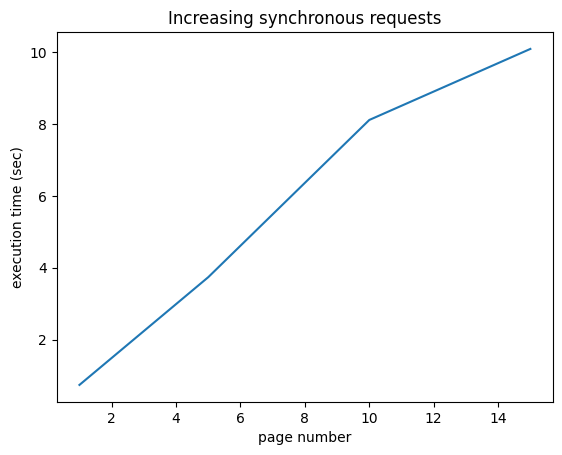

In [396]:
import matplotlib.pyplot as plt
  
# x axis values
x = [i[0] for i in times] # page number
# corresponding y axis values
y = [i[1] for i in times] # execution time
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('page number')
# naming the y axis
plt.ylabel('execution time (sec)')
  
# giving a title to my graph
plt.title('Increasing synchronous requests')
  
# function to show the plot
plt.show()

## Async methods

Asynchronous methods involves making and processing get requests in parallel to speed up large numbers of HTTP requests. It works by sending multiple requests at once (rather than one-by-one) and processing the responses as they are recieved. Here we explore two methods for making API requests asynchronously. The first method uses the `ThreadPoolExecutor` library, and the second method uses the two libraries `asyncio` and `aiohttp`.

### 1) ThreadPoolExecutor

ThreadPoolExecutor is a class from the `concurrent.futures` module that allows you to create a pool of worker threads to execute tasks concurrently. Each thread can make and process a HTTP request. You can use it to run multiple get requests (as seperate threads) in parallel by submitting them to the executor and then waiting for the results. Each time ThreadPoolExecutor creates a new thread, there is a small amount of overhead involved, so if the time it takes to make the request is relatively short, this overhead can make the overall execution time longer than using the synchronous requests module. `ThreadPoolExecutor` is optimal when used to make multiple requests that take time to recieve a response for/ process.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

pages = range(1, 10)

def get_iucn_pages_in_parallel(pages):
    with ThreadPoolExecutor() as executor:
        results = [executor.submit(get_iucn_page, page_number) for page_number in pages] # executor.submit() starts the pool of threads
        for result in results:
            data = result.result()
            return data

Time the HTTP request with the timeit module

In [ ]:
import timeit

execution_time = timeit.timeit(lambda: get_iucn_pages_in_parallel(pages), number=1) 
print(f"Execution time for {max(pages)} pages: {execution_time:.6f} seconds")

### 2) asyncio & aiohttp

**How does asyncio work?**

Asyncio uses coroutines which are awaitable functions that work simarly to generators. Generators are objects that contain iterables which, when requested, are computed and stored in memory, while the rest of the iterables are never generated until they are requested. This means you can store an indefinate number of values without using storage space, its not until you call for the value that it then gets stored in memory. Variables and functions, on the other hand, compute all values in advance and store them in memory. Coroutines work like generators, they are functions that arent executed or stored in memory until called. They are declared with the async and await syntax.

In [2]:
# Generator example

def inner_generator():
    yield 1
    yield 2
    yield 3

def outer_generator():
    yield 'a'
    yield 'b'
    yield 'c'
    inner_yield = yield from inner_generator()
    print(inner_yield)
    yield 'd'
    yield 'e'
    x = yield
    yield x * 3 # send() a value to the geenrator

In [ ]:
# You cant compute and return each variable one at a time in a function

def inner_func():
    return 1
    return 2
    return 3

next(inner_func())

In [4]:
gen = outer_generator()

In [13]:
next(gen)

In [14]:
gen.send(5)

15

Coroutines can be paused and resumed, only generating values as needed. They also have the ability to receive values from the caller, simarly to generators. This is particularly important as it means coroutines and be suspended and resumed later, allowing other tasks to run in the meantime. Asyncio allows you to run processes in parallel by running two or more coroutines concurrently.

**Example of generator vs function**

In [54]:
import requests, json, time

urls = ["https://mockapi_cookbook_1", "https://mockapi_travel_2", "https://mockapi_blog_3", "https://mockapi_holidays_4"]

def get_response(url):
    """ Creates mock response object using fake url """
    info = url.split("_")
    response_data = {'id': info[2], 'title': info[1], 'source': url}
    response = requests.Response()
    response.status_code = 200
    response._content = json.dumps(response_data).encode('utf-8')
    time.sleep(2)
    data = response.json()
    return data

If you make a get requests using a function, the function would make all the requests, store all the responses, and then returned these responses.

In [47]:
def get_multiple_urls(urls):
    """ Uses list of fake urls to return mock response objects """
    for url in urls:
        data = get_response(url)
        return data

[get_url(url) for url in urls]

[{'source': 'https://mockapi_1', 'title': 'Mock Title', 'body': 'Mock Body'},
 {'source': 'https://mockapi_2', 'title': 'Mock Title', 'body': 'Mock Body'},
 {'source': 'https://mockapi_3', 'title': 'Mock Title', 'body': 'Mock Body'},
 {'source': 'https://mockapi_4', 'title': 'Mock Title', 'body': 'Mock Body'}]

If you make a get request using a generator, you can pause and resume the get requests.

In [55]:
def get_multiple_urls(urls):
    for url in urls:
        data = get_response(url)
        yield data

responses = get_multiple_urls(urls)

In [58]:
next(responses)

{'id': '3', 'title': 'blog', 'source': 'https://mockapi_blog_3'}

IMPORTANT NOTICE: Jupyter creates and runs an event loop in the main thread, thus preventing users from being able to start a loop. To run a async function, you have to add your tasks to the already running Jupyter loop.

In [37]:
import asyncio
loop = asyncio.get_event_loop()
print(loop)
pending = asyncio.all_tasks()
print(pending)
try:
    asyncio.get_event_loop().run_until_complete(asyncio.gather(*asyncio.all_tasks()))
except RuntimeError as r:
    print(r)

<_WindowsSelectorEventLoop running=True closed=False debug=False>
{<Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\ipykernel\kernelbase.py:510> cb=[IOLoop.add_future.<locals>.<lambda>() at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\tornado\ioloop.py:687, gather.<locals>._done_callback() at c:\Users\sarah\anaconda3\envs\api-env\lib\asyncio\tasks.py:720]>}
This event loop is already running


If you want to run an additional event loops for development purposes you can use the [nest-asyncio](https://pypi.org/project/nest-asyncio) package, otherwise, you can simply add your async tasks to the already running event loop.

**Example of running multiple coroutines**

In [38]:
import time,asyncio

# create tasks
async def count():
    print("count one")
    await asyncio.sleep(8)
    print("count four")

async def count_further():
    print("count two")
    await asyncio.sleep(4)
    print("count five")

async def count_even_further():
    print("count three")
    await asyncio.sleep(6)
    print("count six")

async def main():
    await asyncio.gather(count(), count_further(), count_even_further()) # gather tasks and await their excecution in the event loop

s = time.perf_counter()
await main()
elapsed = time.perf_counter() - s # time elapsed between starting and ending awaition for async function to finish processing
print(f"Script executed in {elapsed:0.2f} seconds.")

count one
count two
count three
count five
count six
count four
Script executed in 8.00 seconds.


In [39]:
import asyncio
import aiohttp

async def get_iucn_page(session, page_number):
    url = f"http://apiv3.iucnredlist.org/api/v3/species/page/{page_number}?token={IUCN_API_KEY}"
    try:
        async with session.get(url) as response:
            if response.text == '{"message":"Token not valid!"}':
                raise Exception("Token not valid!")
            elif response.status == 404:
                print(f"Page {page_number} not found")
            elif response.status != 200:
                raise Exception(
                    f"Request failed with response status: {response.status}"
                )
            else:
                return await response.json()
    except aiohttp.ClientError as e:
        print(f"Error occured while getting page {page_number} : {e}")
        return None


async def get_multiple_iucn_pages(page_numbers):
    async with aiohttp.ClientSession() as session:
        tasks = [get_iucn_page(session, page_number) for page_number in page_numbers] # create a task for each page request
        results = await asyncio.gather(*tasks) # gather tasks and wait for them to process
        return results


In [13]:
import time
s = time.perf_counter()
await get_multiple_iucn_pages(range(0,2))
elapsed = time.perf_counter() - s
print(f"Script executed in {elapsed:0.2f} seconds.")

Script executed in 18.29 seconds.


In [15]:
# time = timeit.timeit(await get_multiple_iucn_pages(range(0, 2)))

# print(f"Time taken: {time:.6f} seconds")